# Analysis of Sequential MC 

Below we will analyze the role of parameters on the performance of SMC with geometric path whose backward kernel is the reverse of forward kernel.

##### Parameters to evaluate:
- MC method: (2 for now) RWM and MALA
- step size: parameter in the MC step
- number of distributions on the path
- number of steps within each distribution

##### Standard of performance: 
- Variance of normalization factor Z

##### t = 0 Distribution
- Standard Gaussian with dim = 10

##### t = T Distribution
-  Student Distribution with dim = 10 and deg = 5


In [7]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np  

import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

from typing import TypedDict

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.smc.geometric_smc import GeometricSMC
from mcjax.proba.gaussian import IsotropicGauss
from mcjax.proba.neal_funnel import NealFunnel
from mcjax.proba.student import Student

In [8]:
# initialize jax RNG
key = jr.key(0)

In [9]:
dim = 2
mu_0 = jnp.zeros(dim)
sigma_0 = 1.
log_var_0 = jnp.log(sigma_0**2)
log_gamma_0 = IsotropicGauss(mu=mu_0, log_var=log_var_0)

deg = 5
M = np.random.normal(0,1, (dim, dim))
mu = np.random.normal(0,1, dim)
cov = M @ M.T
log_gamma_T = Student(mu=mu, cov=cov, deg=deg)


In [13]:
class Param(TypedDict):
    """ The class of one set of parameters """
    method: str  # MC method
    step_size: float    # step size in MC method
    num_dist: int      # number of distributions on the path
    num_step: int     # number of steps in each distribution 

### Method: RWM v.s. MALA

In [ ]:
def compute_variance(num_dist,step_size, num_substeps, method,num_particles, N=10):
    """ Compute the variance of the (log) estimator """
    coefs = (jnp.arange(num_dist+1)/num_dist).tolist()
    # Initialize the SMC class
    smc = GeometricSMC(log_gamma_0= log_gamma_0, log_gamma_T= log_gamma_T, coefs=coefs, \
                        step_size=step_size, num_substeps=num_substeps)
    
    # Run the SMC
    key_batch = jr.split(key, N)
    batch_run = jax.vmap(smc.single_run, in_axes=(None, 0, None))
    Z_arr = batch_run(num_particles, key_batch, method)
    return jnp.var(Z_arr)
jit_variance_RWM = jax.jit(compute_variance, static_argnames=("method", "N", "num_particles"))


params = [Param(method='RWM', step_size=1, num_dist=num, num_step=10) for num in range(10, 101, 10)] 
print(params[0])
num_particles = 10_000
Z_var_RWM = []
for param in params:
    variance = jit_variance_RWM(
        num_dist=param["num_dist"],
        step_size=param["step_size"],
        num_substeps=param["num_step"],
        method=param["method"],
        num_particles=num_particles,
        N=10
    )
    Z_var_RWM.append((param, variance))

{'method': 'RWM', 'step_size': 1, 'num_dist': 10, 'num_step': 10}


AttributeError: 'dict' object has no attribute 'num_dist'

In [6]:
'''
Compare the variance of Z for two method: RWM and MALA, with fixed step_size and num_step, with num_dist 
varying from 10 to 100
'''
params = [Param(method='RWM', step_size=1, num_dist=num, num_step=10) for num in range(10, 101, 10)] 
num_particles = 10_000
Z_var_RWM = []
for param in params:
    print("Running with param: ", param)
    N,step_size, num_substeps, method = param['num_dist'], param['step_size'], param['num_step'], param['method']
    coefs = (jnp.arange(N+1)/N).tolist()
    GSMC = GeometricSMC(log_gamma_0= log_gamma_0, log_gamma_T= log_gamma_T, coefs=coefs, \
                        step_size=step_size, num_substeps=num_substeps)
    Z_var = GSMC.compute_variance(key,num_particles,method,N = 10)
    Z_var_RWM.append(Z_var)

params = [Param(method='MALA', step_size=1, num_dist=num, num_step=10) for num in range(10, 101, 10)]
Z_var_MALA = []
for param in params:
    print("Running with param: ", param)
    N,step_size, num_substeps, method = param['num_dist'], param['step_size'], param['num_step'], param['method']
    coefs = (jnp.arange(N+1)/N).tolist()
    GSMC = GeometricSMC(log_gamma_0= log_gamma_0, log_gamma_T= log_gamma_T, coefs=coefs, \
                        step_size=step_size, num_substeps=num_substeps)
    states = GSMC.selfadaptive_run(num_particles,key, mc_method=method)
    Z_var = GSMC.compute_variance(key,num_particles,method,N = 10)
    Z_var_MALA.append(Z_var)



NameError: name 'Param' is not defined

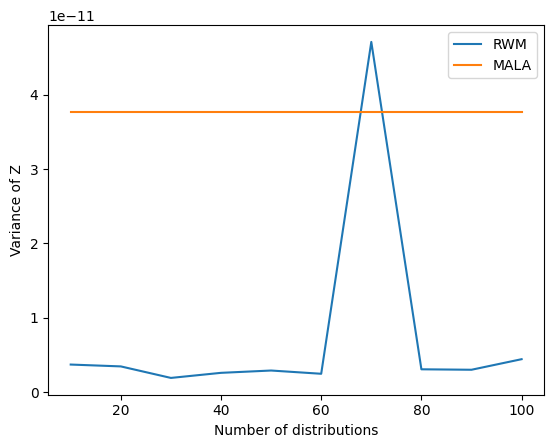

In [ ]:
# Draw the plot
plt.figure()
plt.plot(range(10, 101, 10), Z_var_RWM, label='RWM')    
plt.plot(range(10, 101, 10), Z_var_MALA, label='MALA')
plt.xlabel('Number of distributions')
plt.ylabel('Variance of Z')
plt.legend()
plt.show()

### Number of steps within each distribution

In [ ]:
'''
Compare the variance of Z for different number of steps: 1,2,5,10, with fixed step_size and method = MALA, with num_dist 
varying from 10 to 100
''' 
params = [Param(method='MALA', step_size=1, num_dist=num, num_step=step) for num in range(10, 101, 10) for step in [1,2,5,10]]
Z_var_MALA = []
for param in params:
    N,step_size, num_substeps, method = param['num_dist'], param['step_size'], param['num_step'], param['method']
    coefs = (jnp.arange(N+1)/N).tolist()
    GSMC = GeometricSMC(log_gamma_0= log_gamma_0, log_gamma_T= log_gamma_T, coefs=coefs, \
                        step_size=step_size, num_substeps=num_substeps)
    states = GSMC.selfadaptive_run(num_particles,key, mc_method=method)
    Z_var = GSMC.compute_variance(key,num_particles,method,N = 10)
    Z_var_MALA.append(Z_var)



In [ ]:
# plot the variance of Z for different number of steps
plt.figure()
plt.plot(range(10, 101, 10), Z_var_MALA[:40], label='1 step')
plt.plot(range(10, 101, 10), Z_var_MALA[40:80], label='2 steps')
plt.plot(range(10, 101, 10), Z_var_MALA[80:120], label='5 steps')
plt.plot(range(10, 101, 10), Z_var_MALA[120:], label='10 steps')
plt.xlabel('Number of distributions')
plt.ylabel('Variance of Z')
plt.legend()

### Step size within each distribution

In [ ]:
'''
Compare the variance of Z for different number of step_size: 0.1,0.5,1.0,5.0, with fixed num_step = 5 and method = MALA, with num_dist 
varying from 10 to 100
''' 
params = [Param(method='MALA', step_size=step, num_dist=num, num_step=5) for num in range(10, 101, 10) for step in [0.1,0.5,1.0,5.0]]
Z_var_MALA = []
for param in params:
    N,step_size, num_substeps, method = param['num_dist'], param['step_size'], param['num_step'], param['method']
    coefs = (jnp.arange(N+1)/N).tolist()
    GSMC = GeometricSMC(log_gamma_0= log_gamma_0, log_gamma_T= log_gamma_T, coefs=coefs, \
                        step_size=step_size, num_substeps=num_substeps)
    states = GSMC.selfadaptive_run(num_particles,key, mc_method=method)
    Z_var = GSMC.compute_variance(key,num_particles,method,N = 10)
    Z_var_MALA.append(Z_var)




In [ ]:
# plot
plt.figure()
plt.plot(range(10, 101, 10), Z_var_MALA[:40], label='0.1 step size')
plt.plot(range(10, 101, 10), Z_var_MALA[40:80], label='0.5 step size')
plt.plot(range(10, 101, 10), Z_var_MALA[80:120], label='1.0 step size')
plt.plot(range(10, 101, 10), Z_var_MALA[120:], label='5.0 step size')
plt.xlabel('Number of distributions')
plt.ylabel('Variance of Z')
plt.legend()

